# Autolabel TMA Cores

## NOTE: the functionality of this notebook has been ported over to TSAI (https://tsai.stanford.edu/research/mibi_tsai). $^1$

**NOTE**: Before running this notebook for the first time, make sure you've coregistered your instrument using the *update coregistration parameters* section of  `1_set_up_toffy.ipynb`. This will ensure your FOVs display correctly on the slide.



### Background
This notebook automatically checks the names assigned to the cores on a TMA. In order to get the most benefit out of the notebook, make sure that you've named your FOVs appropriately. The expected format is RNCM, where N is the row and M is the column of the TMA. For example, a core on the third row and second column would be R3C2, and one on the 7th row and first column would be R7C1.  

The script expects that you have already generated and moved the necessary files into the appropriate directory before starting.
- A JSON file defining the four corners of the TMA. **It's important that you have selected them in the correct order; top left, top right, bottom left, bottom right**. Even if one of the cores on the corner is missing, make sure the FOV is located where that corner of the TMA *would* be located, as this is used to define the dimensions of the TMA. You can create this file by exporting the FOVs from the MIBIControl software. 
- A JSON file containing all of the FOVs that you have selected from the TMA, named appropriately. You can create this file by exporting the FOVs from the MIBIControl software. 
- The optical image of your TMA slide. This is automatically created when you load your slide, and is saved to the `D:\\Data\\optical-image` subfolder

In [1]:
import os
from skimage.io import imread

from toffy import tiling_utils, json_utils

# suppress mpl deprecation
import warnings
from matplotlib.cbook import mplDeprecation
warnings.filterwarnings("ignore", category=mplDeprecation)

## 1. Copy over the necessary files to start the script

You will first need to define the prefix `tma_prefix` to use for all of the files associated with this specific TMA. The default is `'example_tma'`, but you should change it to something relevant to your study, such as `'BRCA_TMA_1'`.

Once you have picked your prefix for this specific TMA, you'll need to ensure that all of the necessary files are in the appropriate directory with the correct names:

* `tma_corners_path`: this file, which contains the FOVs defining the four corners of the TMA, should be named `{tma_prefix}_corners.json`.
* `manual_run_path`: this file, which contains the manually selected FOVs from your TMA, should be named `{tma_prefix}_manual.json`.
* `slide_path`: this file, which contains the image of your slide, should be named either `{tma_prefix}.bmp` or `{tma_prefix}.jpg`. This file can be found on the CAC at: `D:\\Data\\optical-image\\`

Each of these files should be copied to `C:\\Users\\Customer.ION\\Documents\\autolabeled_tma_jsons`. More information on the uses and locations of the directories in toffy can be found in the <a href="https://github.com/angelolab/toffy#directory-structure">README</a>.

In [3]:
# define the prefix for each file
tma_prefix = 'example_tma'

In [4]:
# user created files
tma_dir = 'C:\\Users\\Customer.ION\\Documents\\autolabeled_tma_jsons'
tma_dir = '../creed/data_dir/json_tiling_data'
tma_corners_path = os.path.join(tma_dir, '%s_corners.json' % tma_prefix)
manual_run_path = os.path.join(tma_dir, '%s_manual.json' % tma_prefix)

# Change `slide_path_ext` to '.jpg' if needed.
slide_path_ext = '.bmp'
slide_path_ext = '.png'
slide_path = os.path.join(tma_dir, tma_prefix + slide_path_ext)

# the final run file the notebook will generate
remapped_fov_path = os.path.join(tma_dir, '%s_automatic_run.json' % tma_prefix)

# intermediate files the notebook will create
auto_fov_names_path = os.path.join(tma_dir, '%s_automatic_fov_names.json' % tma_prefix)
mapping_path = os.path.join(tma_dir, '%s_mapping.json' % tma_prefix)

## 2. Generate the automatic mapping of FOV names

In [5]:
# define the dimensions of the TMA
tma_num_row = 7
tma_num_col = 4

In [6]:
# generate automatically named TMA
auto_fov_regions = tiling_utils.generate_tma_fov_list(
    tma_corners_path,
    tma_num_row,
    tma_num_col
)

# save the automatically-named TMA FOVs to centroids mapping
json_utils.write_json_file(json_path=auto_fov_names_path, json_object=auto_fov_regions, encoding='utf-8')

# load the user-defined set of FOVs in
manual_fov_regions = json_utils.read_json_file(manual_run_path, encoding='utf-8')

# ensure missing and duplicate FOV names get identified
manual_fov_regions = json_utils.rename_missing_fovs(manual_fov_regions)
manual_fov_regions = json_utils.rename_duplicate_fovs(manual_fov_regions)

# ensure all the provided FOVs in manual_fov_regions lie on the slide
for mf in manual_fov_regions['fovs']:
    mf_coord = (mf['centerPointMicrons']['x'], mf['centerPointMicrons']['y'])
    
    if not tiling_utils.verify_coordinate_on_slide(mf_coord, 'micron'):
        raise ValueError('FOV %s in manual_fov_regions is out of bounds' % mf['name'])

## 3. Set thresholds for identifying incorrect FOV names

### The variables below control the tolerance for identifying when a core has been named incorrectly.

* `check_dist`: set to a positive value to notify of FOV mappings at a distance greater than this value (measured in microns), sorted by decreasing distance. Adjust based on how tightly or sparsely packed the cores are. Set to `None` to bypass.
* `check_duplicates`: set to `True` to flag FOVs in `auto_fov_regions` with multiple FOVs mapping to it. Set to `False` to bypass.
* `check_mismatches`: set to `True` to flag FOVs with mismatched names. Set to `False` to bypass. Assumes FOVs have been named R1C1, R1C2, etc. 

In [7]:
check_dist = 2000
check_duplicates = True
check_mismatches = True

Verify that the names assigned to each TMA core matches. Each FOV in `manual_run_path` is by default mapped to its closest corresponding FOV in `auto_fov_names_path`.

`manual_run_path` cores are shaded red, while `auto_fov_names_path` cores are shaded blue. The highlighted mapping will have a darker shading.

**NOTE: if no remapping needs to be done, click <i>Save mapping</i> to generate the default mapping for the next step.**

1: Inspect using Zoom feature.

<div>
    <img src="img/tma_zoom.gif" width="300" height="274"/>
</div>

2: Toggle TMA core mappings using the *Manually-defined FOV* menu. Reassign TMA core mappings using the *Automatically-generated FOV menu*.

<div>
    <img src="img/tma_selection.gif" width="300" height="274"/>
</div>

3: After you're done, click *Save mapping*. You can always come back and re-run if you change your mind.

Textarea(value='', description='FOV pair validation checks:', layout=Layout(height='auto', width='50%'), style…

Output()

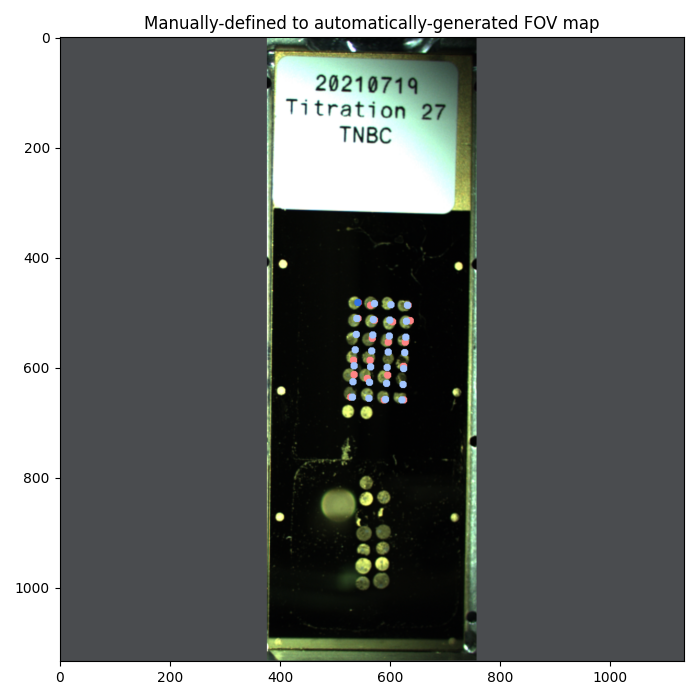

In [11]:
# load the slide image in
slide_data = imread(slide_path)

%matplotlib widget
tiling_utils.tma_interactive_remap(
    manual_fov_regions,
    auto_fov_regions,
    slide_data,
    mapping_path,
    draw_radius=7,
    coreg_path='../toffy/coreg_params.json',
    figsize=(7, 7),
    check_dist=check_dist,
    check_duplicates=check_duplicates,
    check_mismatches=check_mismatches
)

## 4. Set parameters for remapped JSON

Set `randomize` to `True` to shuffle the order of the FOVs in `remapped_fov_regions`. This avoids potential batch effects of acquisition order.

The final run file is saved to `remapped_fov_path`.

In [ ]:
randomize = True

In [ ]:
# load the mapping saved by the interactive visualization
mapping = json_utils.read_json_file(mapping_path, encoding='utf-8')

# rename FOVs, randomize the order, and insert moly points at a specified interval
remapped_fov_regions = tiling_utils.remap_and_reorder_fovs(
    manual_fov_regions,
    mapping,
    randomize=randomize
)

# save remapped_fov_regions
json_utils.write_json_file(json_path=remapped_fov_path, json_object=remapped_fov_regions, encoding='utf-8')

## 5. Run JSON adjustment

If you would like to break up your tma file into smaller JSONs containing a specified amount of FOVs in each, you can do that using the code below. 

`file_split` is a list of values detailing how many FOVs to included in each new file, and must sum to the total number of FOVs in the run file

In [ ]:
file_split = []

json_utils.split_run_file(tma_dir, os.path.basename(remapped_fov_path), file_split)

$^1$ Piyadasa H, Oberlton B, and Kong A, et al. (2023). Rapid Setup of Tissue Microarray and Tiled Area Imaging on the Multiplexed Ion Beam Imaging Microscope using the Tile/SED/Array Interface. <i>J Vis Exp</i>, [OnlineFirst], https://www.jove.com/t/65615/rapid-setup-tissue-microarray-tiled-area-imaging-on-multiplexed-ion